##  Time Series Analysis of Daily Temperature for Berlin- Tempelhof

#### Part 1: Data cleaning, visualisation and preparing the data for the model

###  Import libraries

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

# Set figure size to (16,8)
# plt.rcParams['figure.figsize'] = (14,8)
# Set some easthetic
sns.set()
from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf

plt.rcParams['font.size'] = '16'

### About the Dataset
EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D), file created on 29-10-2022
THESE DATA CAN BE USED FREELY PROVIDED THAT THE FOLLOWING SOURCE IS ACKNOWLEDGED:
Klein Tank, A.M.G. and Coauthors, 2002. Daily dataset of 20th-century surface
air temperature and precipitation series for the European Climate Assessment.
Int. J. of Climatol., 22, 1441-1453.
Data and metadata available at http://www.ecad.eu

MISSING VALUE CODE IS -9999
17-21 TG   : mean temperature in 0.1 &#176;C
23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')
This is the blended series of station GERMANY, BERLIN-TEMPELHOF (STAID: 2759).

**Loading the Data**

In [88]:
df = pd.read_csv('../ECA_blended_berlindata/TG_STAID002759.txt',
                 skiprows = 19, sep = ',',  usecols=[1, 2, 3], parse_dates=True,
                 index_col=0, na_values=['-9999'])

**Inspecting and cleaning the Data**

In [89]:
df.head()

,TG,Q_TG
DATE,,
1876-01-01,22.0,0
1876-01-02,25.0,0
1876-01-03,3.0,0
1876-01-04,-58.0,0
1876-01-05,-98.0,0


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53599 entries, 1876-01-01 to 2022-09-30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0      TG   53404 non-null  float64
 1    Q_TG   53599 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 1.2 MB


In [91]:
# give new column names
df.columns = ['av_temp', 'quality']

In [92]:
df['av_temp'] = df['av_temp'] / 10                ##converting the values to actual temp. values**

In [93]:
df.head()

,av_temp,quality
DATE,,
1876-01-01,2.2,0
1876-01-02,2.5,0
1876-01-03,0.3,0
1876-01-04,-5.8,0
1876-01-05,-9.8,0


**Inspect for missing and suspiscious values**

In [94]:
df['quality'].value_counts()

0    53403
9      195
1        1
Name: quality, dtype: int64

In [95]:
df.loc[df['quality'] == 1]   ## will leave this value in for now, not sure why it is said to be suspiscious

,av_temp,quality
DATE,,
1947-01-21,-2.7,1


In [96]:
df.isna().sum()

av_temp    195
quality      0
dtype: int64

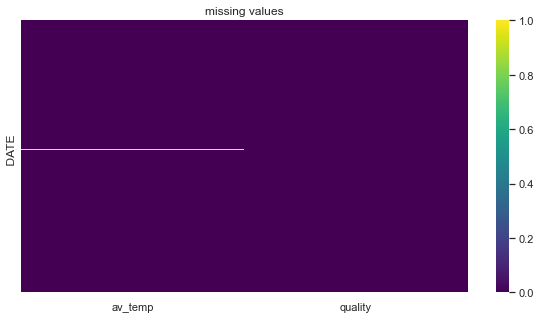

In [97]:
plt.subplots(figsize=(10,5))
sns.heatmap(df.isnull(),yticklabels=False,cmap='viridis').set_title("missing values");

In [98]:
# list of indexes where null values exist
df.loc[df.isnull().any(axis=1)].index

DatetimeIndex(['1945-04-25', '1945-04-26', '1945-04-27', '1945-04-28',
               '1945-04-29', '1945-04-30', '1945-05-01', '1945-05-02',
               '1945-05-03', '1945-05-04',
               ...
               '1945-10-27', '1945-10-28', '1945-10-29', '1945-10-30',
               '1945-10-31', '1945-11-01', '1945-11-02', '1945-11-03',
               '1945-11-04', '1945-11-05'],
              dtype='datetime64[ns]', name='    DATE', length=195, freq=None)

In [99]:
#drop rows with missing values and the extra column not needed for the model'
df = df.dropna().drop('quality',axis=1)

In [100]:
df.isna().sum()

av_temp    0
dtype: int64

In [101]:
df.describe()

,av_temp
count,53404.000000
mean,9.415703
std,7.881617
min,-22.600000
25%,3.400000
50%,9.400000
75%,15.800000
max,30.500000


### Data Visualisation

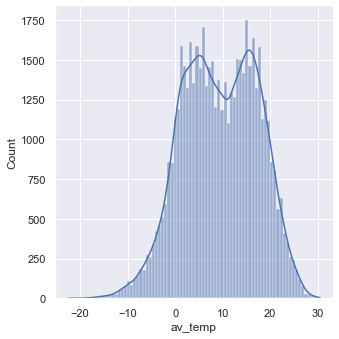

In [103]:
sns.displot(df['av_temp'], kde=True);

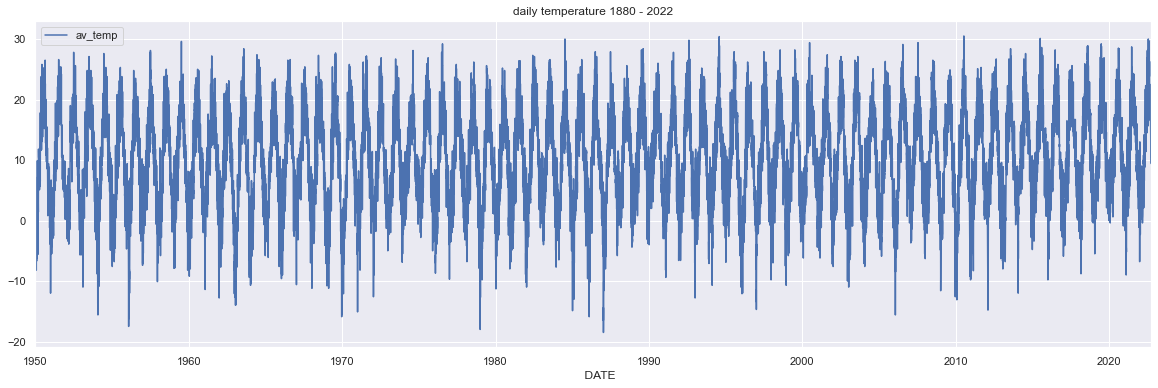

In [114]:
df[["av_temp"]].plot(figsize = (20, 6)).set_title("daily temperature 1880 - 2022");

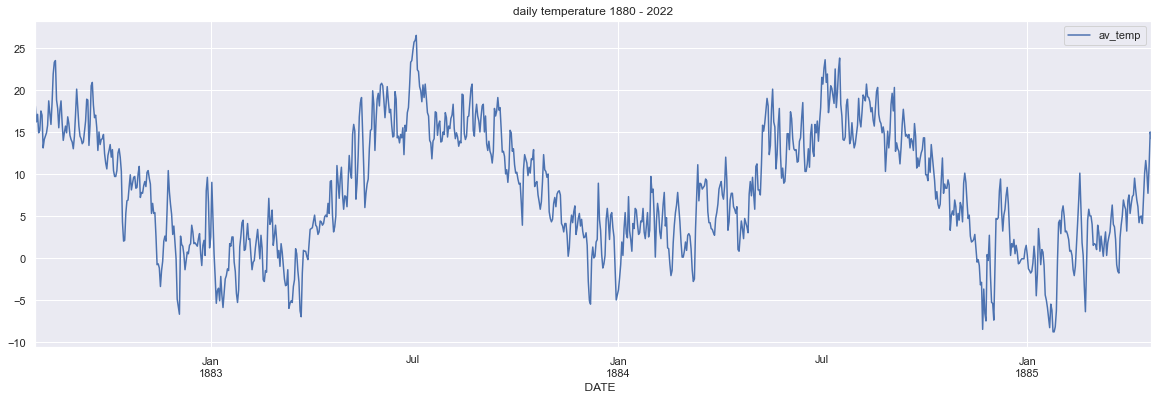

In [105]:
df[["av_temp"]][2400:3400].plot(figsize = (20, 6)).set_title("daily temperature 1880 - 2022");

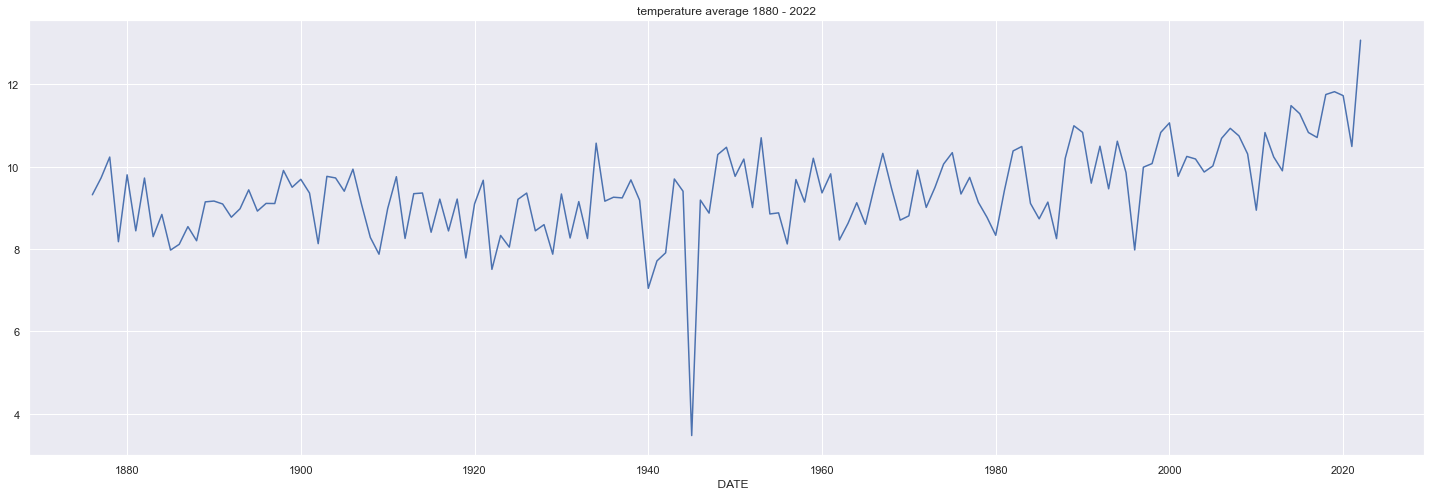

In [106]:
df.groupby([(df.index.year)])['av_temp'].mean().plot(figsize = (25, 8)).set_title("temperature average 1880 - 2022");

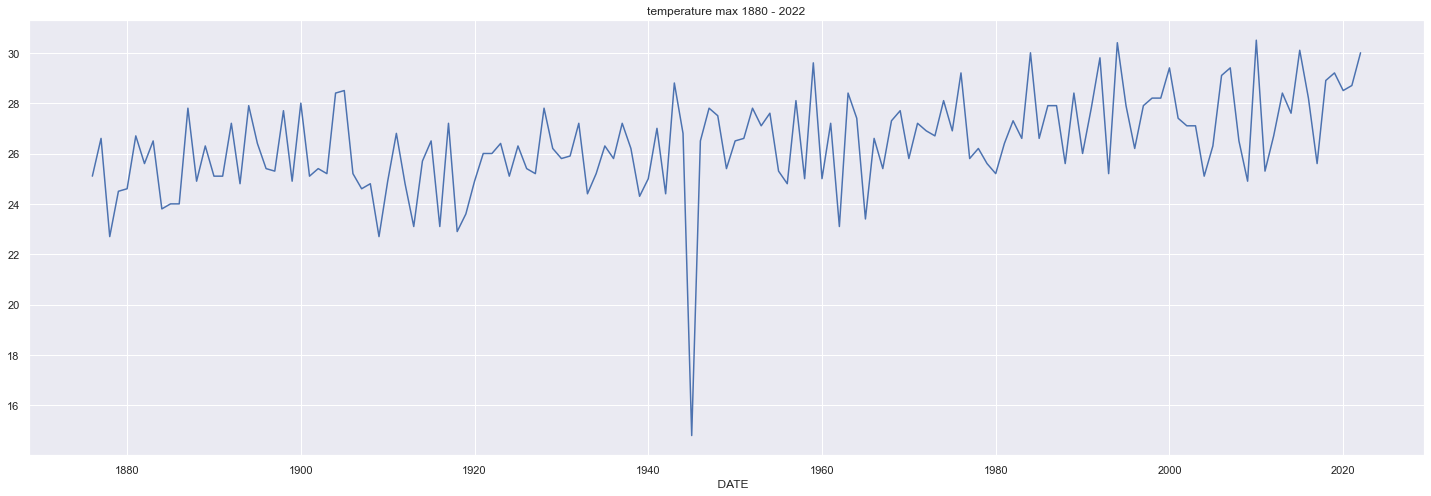

In [107]:
df.groupby([(df.index.year)])['av_temp'].max().plot(figsize = (25, 8)).set_title("temperature max 1880 - 2022");

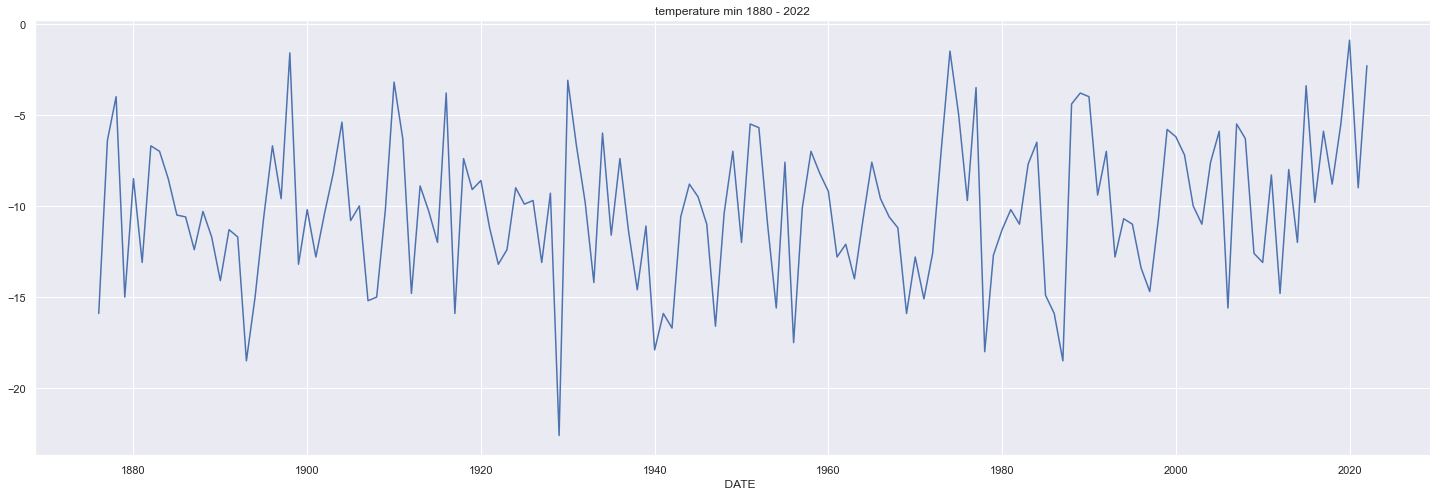

In [108]:
df.groupby([(df.index.year)])['av_temp'].min().plot(figsize = (25, 8)).set_title("temperature min 1880 - 2022");

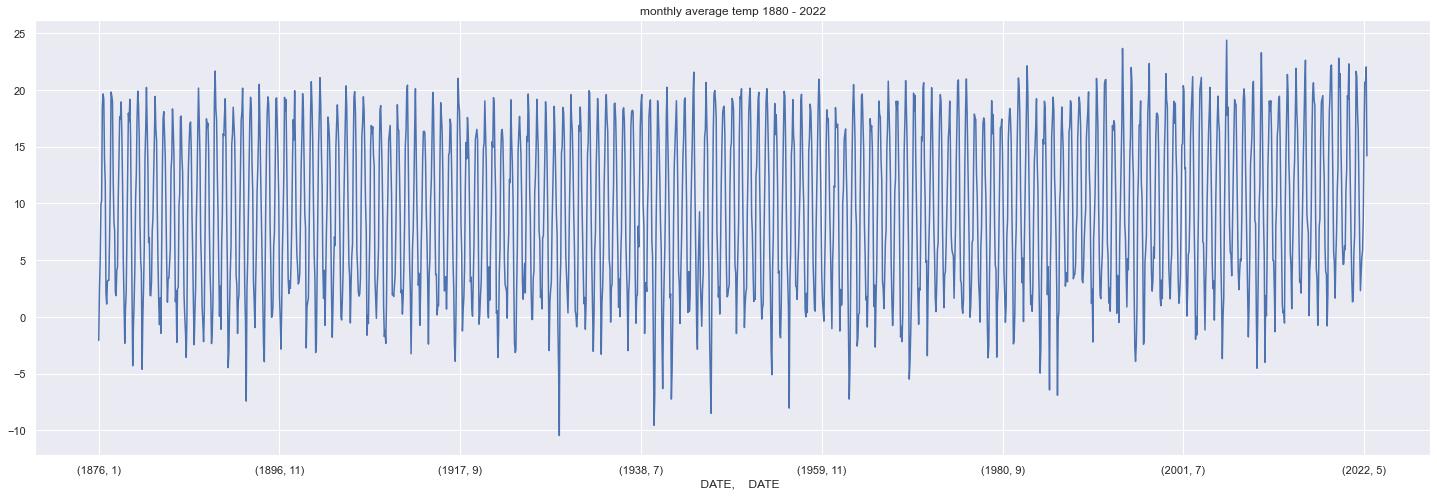

In [109]:
df.groupby([(df.index.year),(df.index.month)])['av_temp'].mean().plot(figsize = (25, 8)).set_title("monthly average temp 1880 - 2022");

###  Subset the data
##### Due to the size of the dataset, and the fact that the older data is not so complete, I will only use the data from 1950 which still represent a good time´-series data for the purpose of this project

In [110]:
df = df[(df.index >= '1950')]    ## subseting the data from 1950 for the model

###  Create Timestep and Seasonal Dummies (OHE) of the month Features
** needed to model the trend and the seasonality properties in the time series**

In [111]:
df['timestep'] = range(len(df))    #Creating the timestep feature
df.head(3)

,av_temp,timestep
DATE,,
1950-01-01,-3.5,0
1950-01-02,1.0,1
1950-01-03,2.9,2


In [ ]:
# Creating dummines and OHE

seasonal_dummies = pd.get_dummies(df.index.month, 
                                  prefix='month', 
                                  drop_first=True).set_index(df.index)
df = df.join(seasonal_dummies)            ##**Append to the temp dataframe the seasonal_dummies**
df.head(3)

In [113]:
df.to_csv('temp_subs_prepared_data.csv') # Saving the data for the model

### Modeling the Trend

**Define X and y, Instantiate and Fit the model**

In [70]:
X = df[['timestep']]
y = df['av_temp']

In [71]:
m = LinearRegression()
m.fit(X,y)

LinearRegression()

**Use the model to redict the trend**

In [72]:
df['trend'] = m.predict(X)
df.head()

,av_temp,timestep,trend
DATE,,,
1950-01-01,-3.5,0,8.844459
1950-01-02,1.0,1,8.844538
1950-01-03,2.9,2,8.844617
1950-01-04,-0.1,3,8.844695
1950-01-05,-3.0,4,8.844774


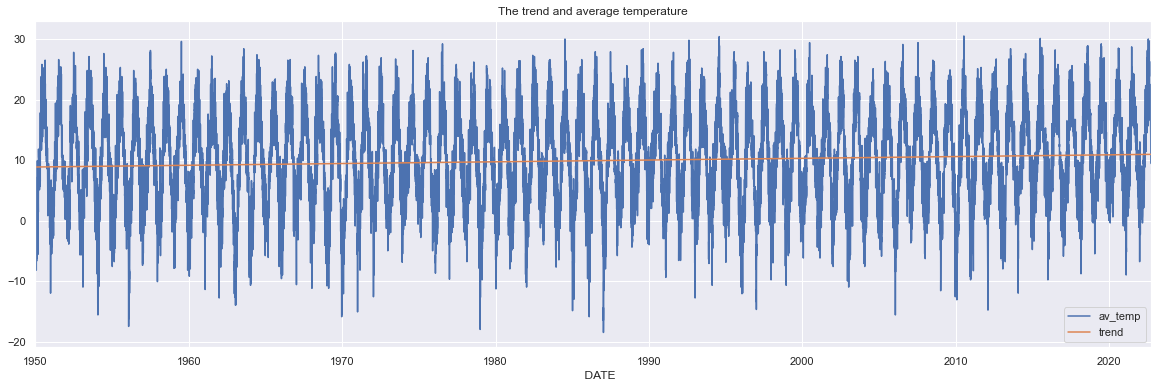

In [73]:
df[["av_temp", "trend"]].plot(figsize = (20, 6)).set_title("The trend and average temperature");

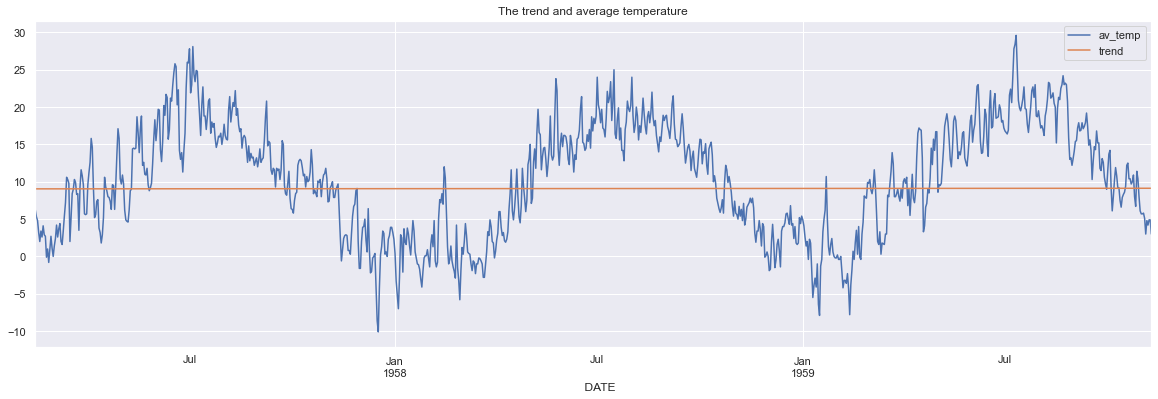

In [74]:
df[["av_temp", "trend"]][2600:3600].plot(figsize = (20, 6)).set_title("The trend and average temperature");

### Modeling the seasonal variability 

#### Re-Define X and y and model the trend with seasonality

In [76]:
X = df.drop(['av_temp', 'trend'], axis = 1)
y = df['av_temp']

In [77]:
m.fit(X,y)

LinearRegression()

**Use the model to predict the trend with seasonality**

In [78]:
df['trend_seasonal'] = m.predict(X)

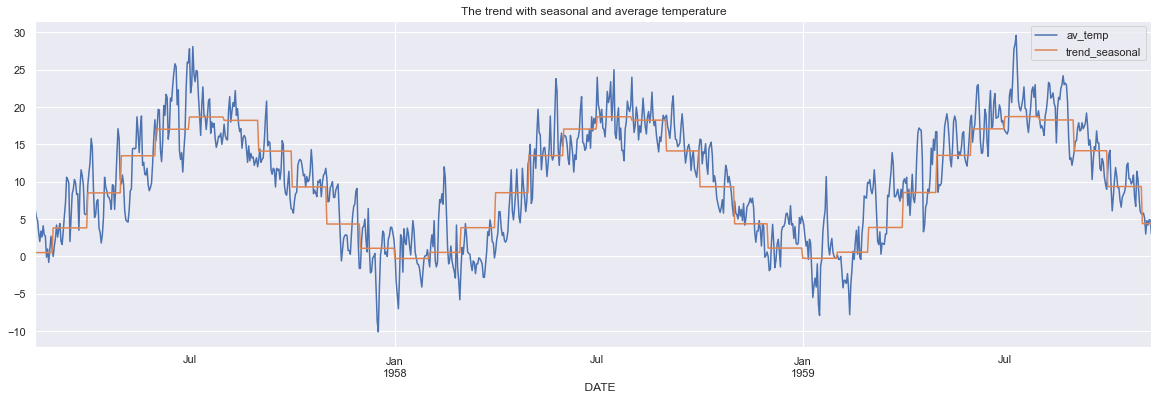

In [82]:
df[["av_temp", "trend_seasonal"]][2600:3600].plot(figsize = (20, 6)).set_title("The trend with seasonal and average temperature");

### Extract the remainder
part of the model that trend and seasonality is not able to explain, the noise. This is what we want to model with AR and ARIMA models for making short term predictions.


In [83]:
df['remainder'] = df['av_temp'] - df['trend_seasonal']

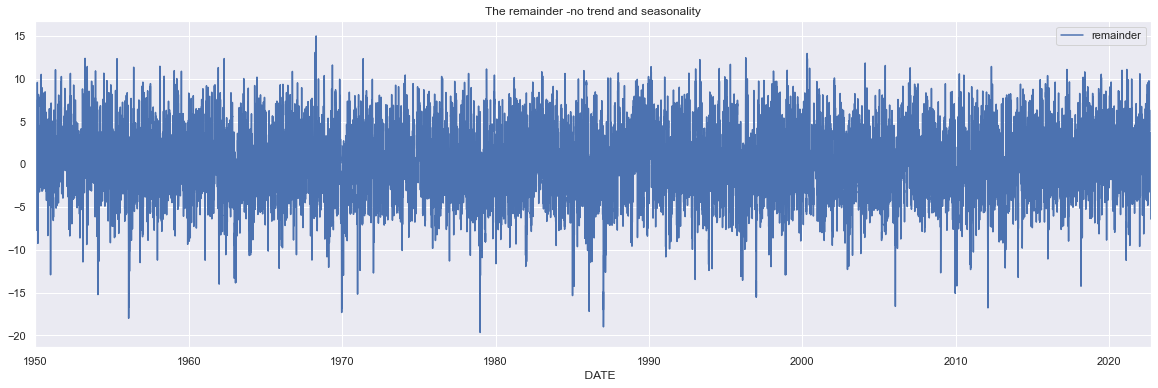

In [84]:
df[["remainder"]].plot(figsize = (20, 6)).set_title("The remainder -no trend and seasonality");

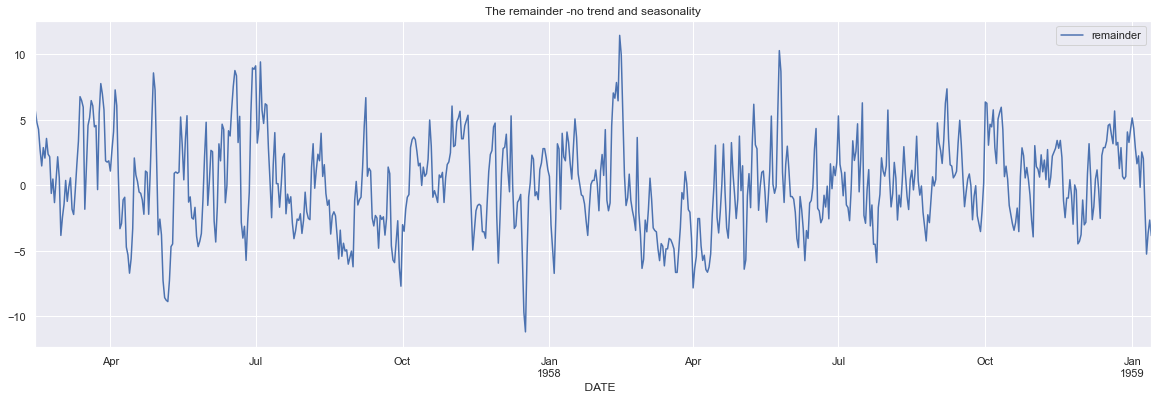

In [86]:
df[["remainder"]][2600:3300].plot(figsize = (20, 6)).set_title("The remainder -no trend and seasonality");

### Save the remainder

In [107]:
df['remainder'].to_csv('temp_remainder.csv')

In [64]:
df.to_csv('temp_subs_full.csv')

<AxesSubplot:xlabel='year', ylabel='remainder'>

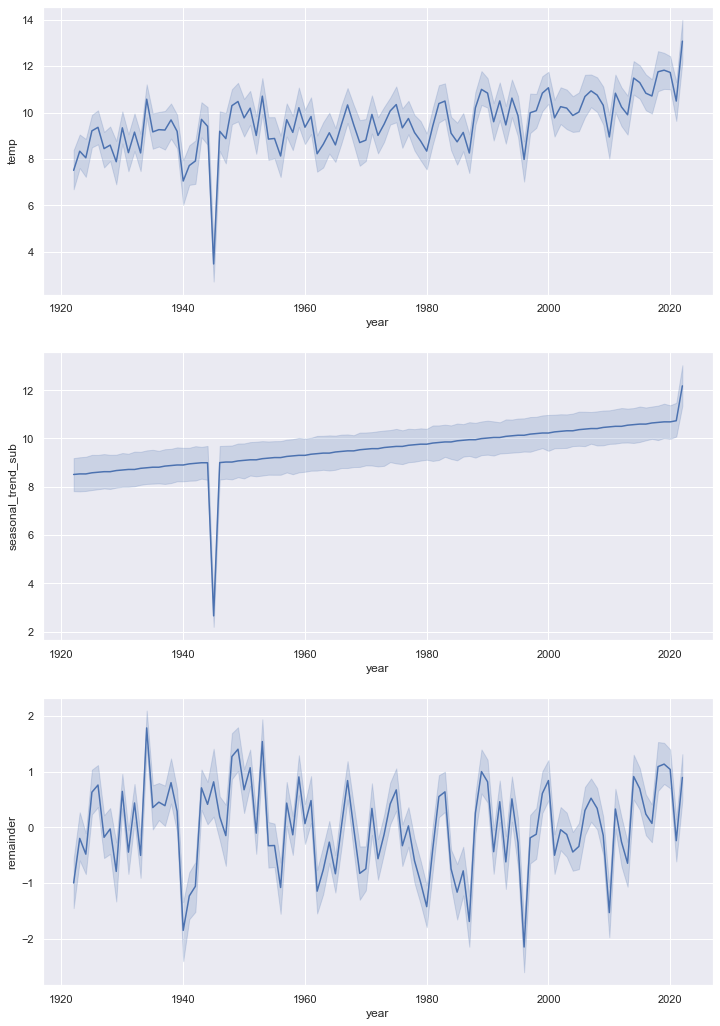

In [93]:
plt.rc('font', size=11)
figure, axes = plt.subplots(nrows=3)
figure.set_size_inches(12,18)
sns.lineplot(x='year', y='av_temp', data=df, ax=axes[0])
sns.lineplot(x='year', y='seasonal_trend_sub', data=df, ax=axes[1])
sns.lineplot(x='year', y='remainder', data=df, ax=axes[2])

<AxesSubplot:xlabel='year', ylabel='remainder2'>

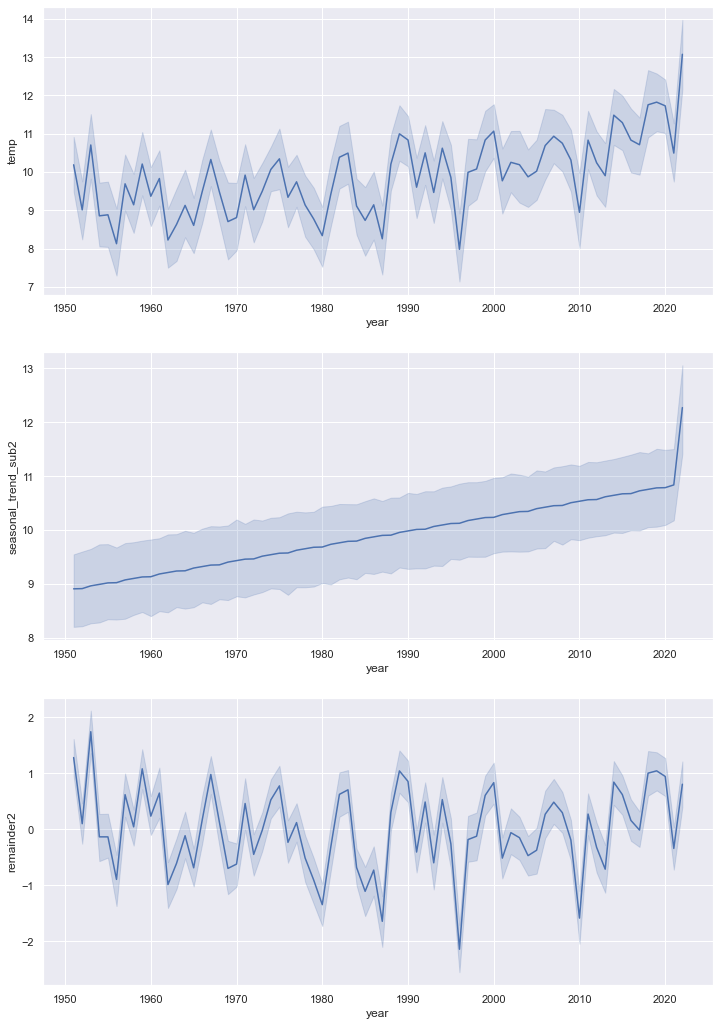

In [105]:
plt.rc('font', size=11)
figure, axes = plt.subplots(nrows=3)
figure.set_size_inches(12,18)
sns.lineplot(x='year', y='av_temp', data=df, ax=axes[0])
sns.lineplot(x='year', y='seasonal_trend_sub2', data=df, ax=axes[1])
sns.lineplot(x='year', y='remainder2', data=df, ax=axes[2])

## Next Notebook: the Autoregressive (AR) Model
